# Business Understanding

The forecasting of future natural gas consumption patterns is essential for energy planning and ensuring a reliable supply. Time series models, such as ARMA and SARIMA, have been shown to effectively capture the seasonality and growth trends in natural gas usage, providing valuable insights for decision-makers. Additionally, accurate forecasts help in managing the economic aspects of natural gas production and consumption, enabling industries to operate more efficiently and reduce economic risks. Understanding consumption patterns through time series analysis supports the development of sustainable energy policies and can guide investment in infrastructure and technology to meet future energy demands. Time series modeling is a vital tool for organizing an analysis base for natural gas inspection and promoting effective and credible energy management in the United States. The stakeholder for this project is North American Electric Reliability Corporation (NERC) and by forecasting natural gas consumption for the next three years, I will be able to provide recommendations for utility and gas companies.

Source: https://www.eia.gov/electricity/data/browser/#/topic/2?agg=2,0,1&fuel=f&geo=g&sec=g&linechart=~ELEC.CONS_TOT.NG-US-99.M&columnchart=ELEC.CONS_TOT.COW-US-99.M&map=ELEC.CONS_TOT.COW-US-99.M&freq=M&start=200101&end=202312&ctype=linechart&ltype=pin&rtype=s&maptype=0&rse=0&pin=

# Data Understanding

For this analysis I collected data from the United States Energy Information Administration and within the dataset there are the monthly consumption totals of coal, petroleum liquids, petroleum coke and natural gas for all sectors. This dataset has every month’s usage since January 1, 2001, and ends on December 1, 2023.

In [1]:
#importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import itertools
import seaborn as sns

from random import gauss as gs
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose


warnings.filterwarnings("ignore")


C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\lbrown\Anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#loading the dataset

data = pd.read_csv("data/Total_consumption_for_all_sectors.csv", skiprows=4)
data.head()

,description,units,source key,1/1/2001,2/1/2001,3/1/2001,4/1/2001,5/1/2001,6/1/2001,7/1/2001,...,3/1/2023,4/1/2023,5/1/2023,6/1/2023,7/1/2023,8/1/2023,9/1/2023,10/1/2023,11/1/2023,12/1/2023
0,Total consumption for all sectors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,NaN,ELEC.CONS_TOT..M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States : coal,thousand tons,ELEC.CONS_TOT.COW-US-99.M,90951.0,77545.0,80268.0,72530.0,78810.0,84486.0,93653.0,...,29462.0,23614.0,26353.0,34220.0,45286.0,44618.0,34973.0,30374.0,30386.0,32784.0
3,United States : petroleum liquids,thousand barrels,ELEC.CONS_TOT.PEL-US-99.M,32350.0,17915.0,20239.0,19059.0,17661.0,20112.0,18089.0,...,2063.0,1856.0,1923.0,1828.0,1897.0,1976.0,1866.0,1973.0,1990.0,2177.0
4,United States : petroleum coke,thousand tons,ELEC.CONS_TOT.PC-US-99.M,393.0,357.0,354.0,297.0,346.0,359.0,425.0,...,173.0,157.0,173.0,198.0,306.0,315.0,278.0,177.0,136.0,176.0


## Data Preparation

This dataset is in the form of a csv and currently the datatypes are all strings. First I will need to drop rows and columns that do not contain any data, then I will change the index to date and transpose the dataset so that each date will have it's corresponding natural gas comsumption amount. Finally, since for this analysis I am only focusing on Natural Gas, I will drop all columns other than "Natural Gas" and get the descriptive statistics on the new dataset. 

In [3]:
#dropping unnecessary columns

dataset = data.drop(['units', 'source key'], axis=1)
dataset.head()

,description,1/1/2001,2/1/2001,3/1/2001,4/1/2001,5/1/2001,6/1/2001,7/1/2001,8/1/2001,9/1/2001,...,3/1/2023,4/1/2023,5/1/2023,6/1/2023,7/1/2023,8/1/2023,9/1/2023,10/1/2023,11/1/2023,12/1/2023
0,Total consumption for all sectors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States : coal,90951.0,77545.0,80268.0,72530.0,78810.0,84486.0,93653.0,95669.0,81256.0,...,29462.0,23614.0,26353.0,34220.0,45286.0,44618.0,34973.0,30374.0,30386.0,32784.0
3,United States : petroleum liquids,32350.0,17915.0,20239.0,19059.0,17661.0,20112.0,18089.0,23892.0,11997.0,...,2063.0,1856.0,1923.0,1828.0,1897.0,1976.0,1866.0,1973.0,1990.0,2177.0
4,United States : petroleum coke,393.0,357.0,354.0,297.0,346.0,359.0,425.0,414.0,386.0,...,173.0,157.0,173.0,198.0,306.0,315.0,278.0,177.0,136.0,176.0


In [4]:
#dropping the first two rows
dataset = dataset.drop(dataset.index[:2])
dataset.head()

,description,1/1/2001,2/1/2001,3/1/2001,4/1/2001,5/1/2001,6/1/2001,7/1/2001,8/1/2001,9/1/2001,...,3/1/2023,4/1/2023,5/1/2023,6/1/2023,7/1/2023,8/1/2023,9/1/2023,10/1/2023,11/1/2023,12/1/2023
2,United States : coal,90951.0,77545.0,80268.0,72530.0,78810.0,84486.0,93653.0,95669.0,81256.0,...,29462.0,23614.0,26353.0,34220.0,45286.0,44618.0,34973.0,30374.0,30386.0,32784.0
3,United States : petroleum liquids,32350.0,17915.0,20239.0,19059.0,17661.0,20112.0,18089.0,23892.0,11997.0,...,2063.0,1856.0,1923.0,1828.0,1897.0,1976.0,1866.0,1973.0,1990.0,2177.0
4,United States : petroleum coke,393.0,357.0,354.0,297.0,346.0,359.0,425.0,414.0,386.0,...,173.0,157.0,173.0,198.0,306.0,315.0,278.0,177.0,136.0,176.0
5,United States : natural gas,457588.0,417044.0,476649.0,491067.0,543473.0,604362.0,755894.0,813932.0,629412.0,...,1062127.0,982039.0,1114670.0,1300402.0,1599998.0,1590772.0,1317030.0,1139689.0,1093508.0,1153560.0


In [5]:
#changing the column name from description to date
dataset = dataset.rename(columns={'description': 'Date'})
dataset.head()

,Date,1/1/2001,2/1/2001,3/1/2001,4/1/2001,5/1/2001,6/1/2001,7/1/2001,8/1/2001,9/1/2001,...,3/1/2023,4/1/2023,5/1/2023,6/1/2023,7/1/2023,8/1/2023,9/1/2023,10/1/2023,11/1/2023,12/1/2023
2,United States : coal,90951.0,77545.0,80268.0,72530.0,78810.0,84486.0,93653.0,95669.0,81256.0,...,29462.0,23614.0,26353.0,34220.0,45286.0,44618.0,34973.0,30374.0,30386.0,32784.0
3,United States : petroleum liquids,32350.0,17915.0,20239.0,19059.0,17661.0,20112.0,18089.0,23892.0,11997.0,...,2063.0,1856.0,1923.0,1828.0,1897.0,1976.0,1866.0,1973.0,1990.0,2177.0
4,United States : petroleum coke,393.0,357.0,354.0,297.0,346.0,359.0,425.0,414.0,386.0,...,173.0,157.0,173.0,198.0,306.0,315.0,278.0,177.0,136.0,176.0
5,United States : natural gas,457588.0,417044.0,476649.0,491067.0,543473.0,604362.0,755894.0,813932.0,629412.0,...,1062127.0,982039.0,1114670.0,1300402.0,1599998.0,1590772.0,1317030.0,1139689.0,1093508.0,1153560.0


In [6]:
#setting Date as the index
dataset.set_index('Date', inplace=True)
dataset.head()

,1/1/2001,2/1/2001,3/1/2001,4/1/2001,5/1/2001,6/1/2001,7/1/2001,8/1/2001,9/1/2001,10/1/2001,...,3/1/2023,4/1/2023,5/1/2023,6/1/2023,7/1/2023,8/1/2023,9/1/2023,10/1/2023,11/1/2023,12/1/2023
Date,,,,,,,,,,,,,,,,,,,,,
United States : coal,90951.0,77545.0,80268.0,72530.0,78810.0,84486.0,93653.0,95669.0,81256.0,77816.0,...,29462.0,23614.0,26353.0,34220.0,45286.0,44618.0,34973.0,30374.0,30386.0,32784.0
United States : petroleum liquids,32350.0,17915.0,20239.0,19059.0,17661.0,20112.0,18089.0,23892.0,11997.0,10551.0,...,2063.0,1856.0,1923.0,1828.0,1897.0,1976.0,1866.0,1973.0,1990.0,2177.0
United States : petroleum coke,393.0,357.0,354.0,297.0,346.0,359.0,425.0,414.0,386.0,408.0,...,173.0,157.0,173.0,198.0,306.0,315.0,278.0,177.0,136.0,176.0
United States : natural gas,457588.0,417044.0,476649.0,491067.0,543473.0,604362.0,755894.0,813932.0,629412.0,587134.0,...,1062127.0,982039.0,1114670.0,1300402.0,1599998.0,1590772.0,1317030.0,1139689.0,1093508.0,1153560.0


In [7]:
#transposing the dataset so that the dates will be the index
data_transpose = dataset.transpose()
data_transpose.head()

Date,United States : coal,United States : petroleum liquids,United States : petroleum coke,United States : natural gas
1/1/2001,90951.0,32350.0,393.0,457588.0
2/1/2001,77545.0,17915.0,357.0,417044.0
3/1/2001,80268.0,20239.0,354.0,476649.0
4/1/2001,72530.0,19059.0,297.0,491067.0
5/1/2001,78810.0,17661.0,346.0,543473.0


In [8]:
#changing the data type of the index to datetime
data_transpose.index = pd.to_datetime(data_transpose.index)

In [9]:
#renaming the target column

data_transpose.rename(columns={'United States : natural gas': 'Natural Gas (Mcf)'}, inplace=True)
data_transpose.head()

Date,United States : coal,United States : petroleum liquids,United States : petroleum coke,Natural Gas (Mcf)
2001-01-01,90951.0,32350.0,393.0,457588.0
2001-02-01,77545.0,17915.0,357.0,417044.0
2001-03-01,80268.0,20239.0,354.0,476649.0
2001-04-01,72530.0,19059.0,297.0,491067.0
2001-05-01,78810.0,17661.0,346.0,543473.0


In [10]:
#dropping unnecessary columns

natural_gas = data_transpose.drop(['United States : coal', 'United States : petroleum liquids', 
                                   'United States : petroleum coke'], axis=1)

In [11]:
natural_gas

Date,Natural Gas (Mcf)
2001-01-01,457588.0
2001-02-01,417044.0
2001-03-01,476649.0
2001-04-01,491067.0
2001-05-01,543473.0
...,...
2023-08-01,1590772.0
2023-09-01,1317030.0
2023-10-01,1139689.0
2023-11-01,1093508.0


In [12]:
#making sure that the index is in the proper format
natural_gas.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', length=276, freq=None)

In [13]:
natural_gas.describe()

Date,Natural Gas (Mcf)
count,2.760000e+02
mean,8.082169e+05
std,2.586120e+05
min,4.145690e+05
25%,5.910722e+05
50%,7.848305e+05
75%,9.835740e+05
max,1.599998e+06


In [14]:
natural_gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2001-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Natural Gas (Mcf)  276 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


# Exploratory Data Analysis

For this section, I wanted to show what the dataset looked like all together on a line graph, so that we can clearly see the trend. It was also important to split the dataset in two, train and valid, so that we can train the dataset on one group and then test the model on unseen data. The training set has 80% of the data and the test set has 20% of the data. 

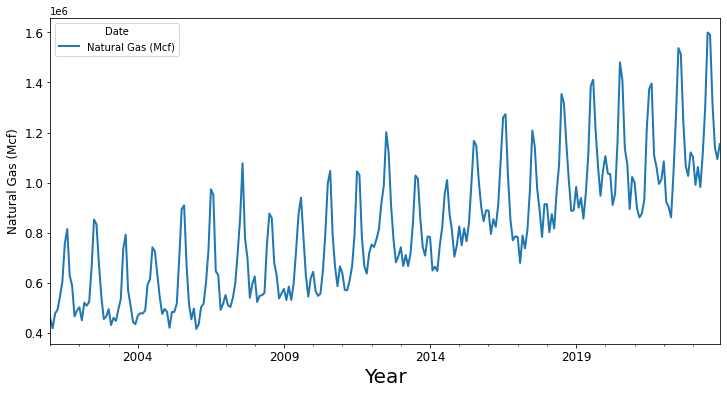

In [15]:
#plotting the entire dataset
natural_gas.plot(figsize=(12, 6), linewidth=2, fontsize=12)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Natural Gas (Mcf)", fontsize=12);

In [16]:
#splitting the data between train and validation sets 80/20

split = round(natural_gas.shape[0]*0.8)
split

221

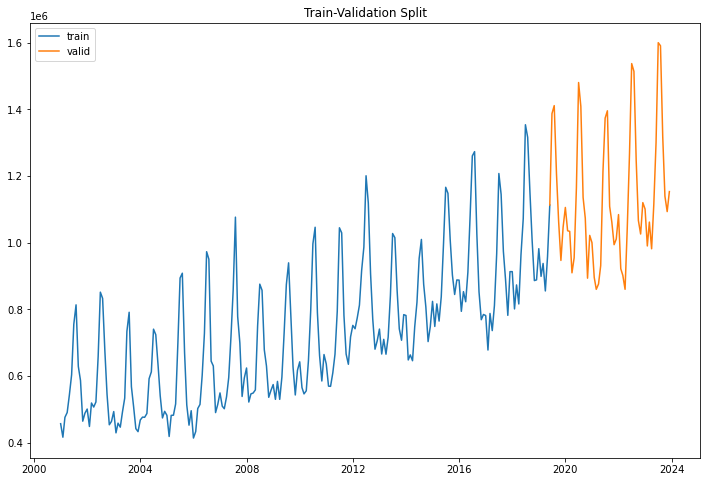

In [17]:
# Define train and test sets according to the index found above
train = natural_gas[:(split+1)]

valid = natural_gas[split:]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train, label='train')
# ax.plot(valid)
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

# Modeling

I created several models for this analysis, starting with a simple naive baseline model, then have two versions of each Autoregrssive, Moving Average and ARMA models. Finally, the dataset was run through a SARIMAX model that takes into account the seasonality of the data. My goal was to improve the results through each interation and end with the best performing model. The metrics that are used for success in time series analysis problems is RMSE (Root Mean Squared Error) and AIC (Akaike information criterion.) For this analysis, the smaller the score, the better. 

## Baseline Model

First I built the baseline naive model, where the datset is shifted by 1 and is now equal to the day before. The RMSE value for this model will be what I try to improve upon and compare against when I create the other models to follow. 

In [18]:
train

Date,Natural Gas (Mcf)
2001-01-01,457588.0
2001-02-01,417044.0
2001-03-01,476649.0
2001-04-01,491067.0
2001-05-01,543473.0
...,...
2019-02-01,899291.0
2019-03-01,938027.0
2019-04-01,855587.0
2019-05-01,958545.0


In [19]:
#shifting the dataset by 1

baseline = train.shift(1)
baseline

Date,Natural Gas (Mcf)
2001-01-01,NaN
2001-02-01,457588.0
2001-03-01,417044.0
2001-04-01,476649.0
2001-05-01,491067.0
...,...
2019-02-01,982335.0
2019-03-01,899291.0
2019-04-01,938027.0
2019-05-01,855587.0


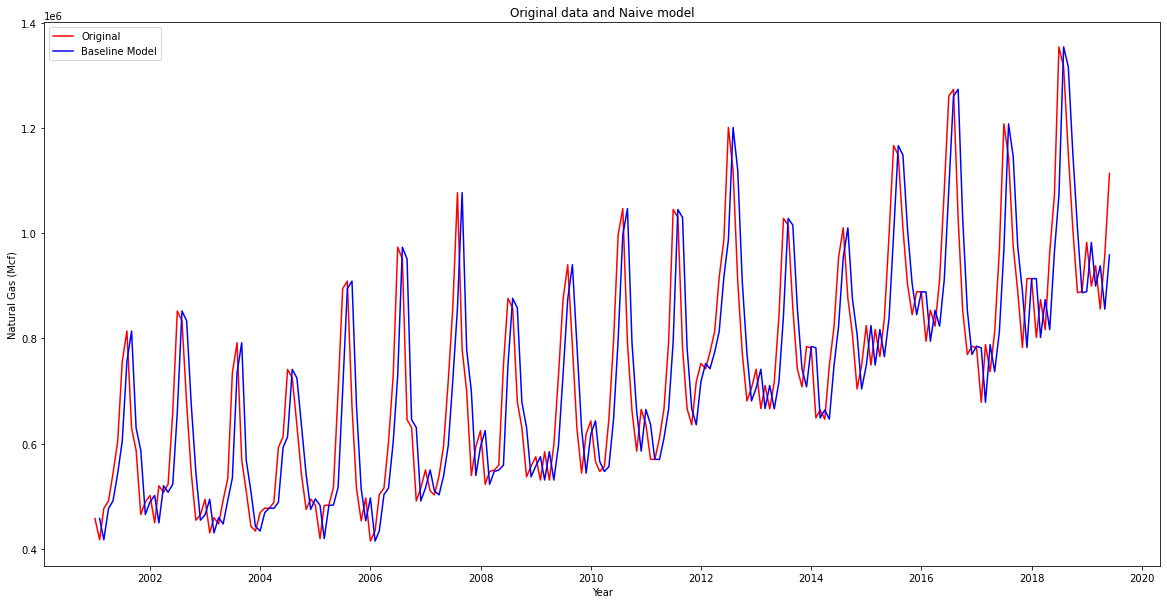

In [20]:
#plotting both the original and shifted dataset. The blue line is the shifted data and is equal to the day before.

fig = plt.figure(figsize=(20,10))
plt.plot(train, color='red', label='Original')
plt.plot(baseline, color='blue', label='Baseline Model')
plt.legend(loc='best')
plt.title('Original data and Naive model')
plt.xlabel("Year")
plt.ylabel("Natural Gas (Mcf)")
plt.show(block=False)

The RMSE value for the baseline is one of the values I will be comparing the models by. RMSE equals the difference between the predicted value and the true value in the original dataset. This basically shows us how close our model is to predicting the correct value, so the smaller the value, the better but it is relative to the values in the dataset.

In [21]:
#calculating root mean squared error
rmse_baseline = np.sqrt(mean_squared_error(train[1:], baseline.dropna()))
rmse_baseline

108531.10297970324

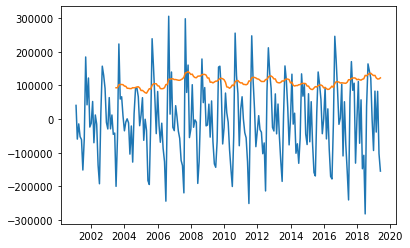

In [22]:
#plotting the residuals which allows us to see whether there may be some trend information that is not captured by our model

fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:]
ax.plot(residuals.index.to_numpy(), residuals.to_numpy())
ax.plot(residuals.index.to_numpy(), residuals.rolling(30).std().to_numpy());

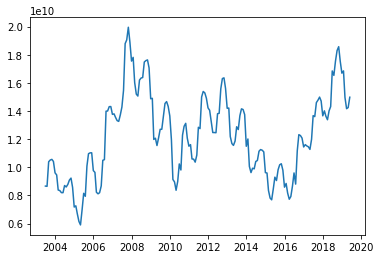

In [23]:
#plotting rolling standard deviation of the errors

fig, ax = plt.subplots()

ax.plot(residuals.index.to_numpy(), residuals.rolling(30).var().to_numpy());

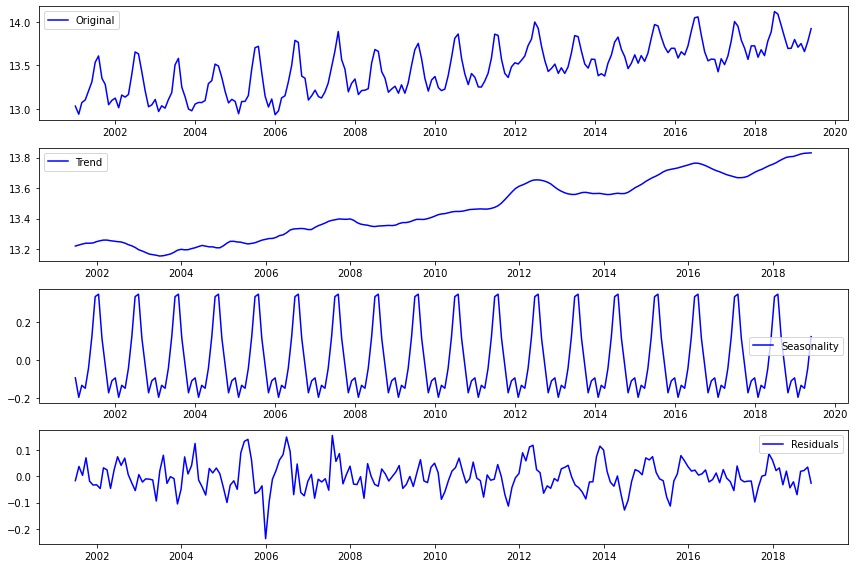

In [24]:
#creating Time Series Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(train))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

We can see from this decomposition chart that there is an upward trend, which indicates a general overall growth in the production of natural gas.
We can also see a seasonality, with lags of 1 year, with high peaks in the middle of the year.
We can't really see a pattern in the residulas, which is what we want.

## Autoregressive Model (AR)

In this section, I will begin working on ARMA models, Autoregressive Moving Average models, which are used to describe weakly stationary stochastic processes. They combine two components:

Autoregressive (AR): This part models the variable as a linear combination of its own previous values. The AR part is denoted as AR(p), where ( p ) represents the number of lag terms used in the model.

Moving Average (MA): This part models the variable by using the past forecast errors in a regression-like model. It is denoted as MA(q), where ( q ) represents the number of lagged forecast errors in the prediction equation.

I will first start with two AR models, then move on to two MA models. Finally, I will use ACF and PACF charts to determine the best parameters for the ARMA model. 

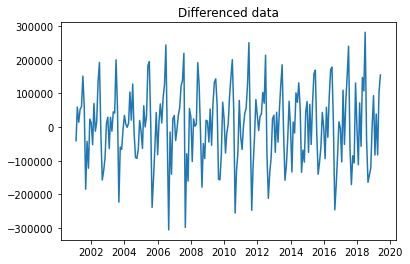

In [25]:
#differencing the data to remove the trend

train_diff = train.diff().dropna()

fig, ax = plt.subplots()
ax.plot(train_diff)
ax.set_title('Differenced data');

In [26]:
#first AR model with simple parameters
ar_1 = ARIMA(train_diff, order=(1, 1, 0)).fit()

ar_1.predict(typ='levels')

2001-02-01        0.000000
2001-03-01   -32729.404357
2001-04-01    40300.707055
2001-05-01    23128.052874
2001-06-01    45083.595579
                  ...     
2019-02-01    75911.693498
2019-03-01   -49007.579870
2019-04-01    15262.208002
2019-05-01   -59082.632459
2019-06-01    67221.474390
Freq: MS, Name: predicted_mean, Length: 221, dtype: float64

In [27]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2891.429
Date:                Mon, 01 Apr 2024   AIC                           5786.857
Time:                        16:33:38   BIC                           5793.644
Sample:                    02-01-2001   HQIC                          5789.598
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1928      0.058     -3.333      0.001      -0.306      -0.079
sigma2      1.528e+10   3.81e-13   4.01e+22      0.000    1.53e+10    1.53e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                40.37
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.95
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [28]:
#AIC score
ar_1.aic

5786.857243413682

In [29]:
#root mean squared error for AR 1
y_hat_ar1 = ar_1.predict(typ='levels')
rmse_ar1 = np.sqrt(mean_squared_error(train_diff, y_hat_ar1))
rmse_ar1

123240.7663471049

In [30]:
#running another AR model but with 2 in the position of class order

ar_2 = ARIMA(train_diff, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

2001-02-01        0.000000
2001-03-01   -32719.728100
2001-04-01    43570.661729
2001-05-01     8943.266261
2001-06-01    50952.159584
                  ...     
2019-02-01    53923.160609
2019-03-01   -57869.014363
2019-04-01    39000.320219
2019-05-01   -74330.791192
2019-06-01    80436.102528
Freq: MS, Name: predicted_mean, Length: 221, dtype: float64

In [31]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                  221
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2888.772
Date:                Mon, 01 Apr 2024   AIC                           5783.545
Time:                        16:33:38   BIC                           5793.726
Sample:                    02-01-2001   HQIC                          5787.656
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2230      0.063     -3.524      0.000      -0.347      -0.099
ar.L2         -0.1553      0.080     -1.946      0.052      -0.312       0.001
sigma2      1.498e+10   4.58e-13   3.27e+22      0.000     1.5e+10     1.5e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                33.03
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.85
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [32]:
print(ar_1.aic)
print(ar_2.aic)

5786.857243413682
5783.544735234488


In [33]:
y_hat_ar1 = ar_2.predict(typ='levels')
rmse_ar2 = np.sqrt(mean_squared_error(train_diff, y_hat_ar1))
rmse_ar2

121758.42416977046

## Moving Average Model (MA)

In [34]:
#first MA model with 1 in parameter
ma_1 = ARIMA(train_diff, order=(0, 1, 1)).fit()
y_hat_ma1 = ma_1.predict(typ='levels')
rmse_ma1 = np.sqrt(mean_squared_error(train_diff, y_hat_ma1))

In [35]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                  221
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2868.579
Date:                Mon, 01 Apr 2024   AIC                           5741.158
Time:                        16:33:39   BIC                           5747.946
Sample:                    02-01-2001   HQIC                          5743.899
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9965      0.101     -9.907      0.000      -1.194      -0.799
sigma2      1.498e+10   4.73e-12   3.17e+21      0.000     1.5e+10     1.5e+10
===================================================================================
Ljung-Box (L1) (Q):                  23.84   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.00   Prob(JB):                         0.57
Heteroskedasticity (H):               1.23   Skew:                            -0.17
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.44e+36. Standard errors may be unstable.
"""

In [36]:
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

5786.857243413682
5783.544735234488
5741.158371072335


In [37]:
rmse_ma1

109449.39895391688

In [38]:
#second MA model with 2 in parameters
ma_2 = ARIMA(train_diff, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

2001-02-01        0.000000
2001-03-01   -29564.654981
2001-04-01    36864.904577
2001-05-01     1939.496884
2001-06-01    35154.784930
                  ...     
2019-02-01    30952.301701
2019-03-01   -38316.426931
2019-04-01    29433.686956
2019-05-01   -37820.919271
2019-06-01    52053.735621
Freq: MS, Name: predicted_mean, Length: 221, dtype: float64

In [39]:
ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                  221
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2854.780
Date:                Mon, 01 Apr 2024   AIC                           5715.561
Time:                        16:33:39   BIC                           5725.742
Sample:                    02-01-2001   HQIC                          5719.672
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6430      0.124     -5.185      0.000      -0.886      -0.400
ma.L2         -0.3524      0.089     -3.977      0.000      -0.526      -0.179
sigma2      1.347e+10   6.59e-12   2.04e+21      0.000    1.35e+10    1.35e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 3.86
Prob(Q):                              0.76   Prob(JB):                         0.15
Heteroskedasticity (H):               1.26   Skew:                            -0.31
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.72e+35. Standard errors may be unstable.
"""

In [40]:
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

5786.857243413682
5783.544735234488
5741.158371072335
5715.560939174736


In [41]:
y_hat_ma2 = ma_2.predict(typ='levels')
rmse_ma2 = np.sqrt(mean_squared_error(train_diff, y_hat_ma2))
rmse_ma2

102586.24310891026

## ARMA Model

Since both the AR 2 and the MA 2 model performed better than the first, I will start the ARMA model with 2 in each p and q parameters. Then, I will use ACF and PACF to get the optimal parameters for the model.

In [42]:
#first ARMA model
arma_1 = ARIMA(train_diff, order=(2, 1, 2)).fit()

In [43]:
arma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                  221
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2832.766
Date:                Mon, 01 Apr 2024   AIC                           5675.533
Time:                        16:33:39   BIC                           5692.501
Sample:                    02-01-2001   HQIC                          5682.385
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1218      0.095     11.783      0.000       0.935       1.308
ar.L2         -0.5239      0.107     -4.901      0.000      -0.733      -0.314
ma.L1         -1.9812      0.096    -20.714      0.000      -2.169      -1.794
ma.L2          0.9830      0.096     10.245      0.000       0.795       1.171
sigma2      1.319e+10   3.79e-12   3.48e+21      0.000    1.32e+10    1.32e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):                 4.76
Prob(Q):                              0.34   Prob(JB):                         0.09
Heteroskedasticity (H):               1.21   Skew:                             0.31
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.47e+36. Standard errors may be unstable.
"""

In [44]:
y_hat_arma1 = arma_1.predict(typ='levels')
rmse_arma1 = np.sqrt(mean_squared_error(train_diff, y_hat_arma1))
rmse_arma1

87941.9756234161

In [45]:
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_1.aic)

5786.857243413682
5783.544735234488
5741.158371072335
5715.560939174736
5675.532779493358


## ACF and PACF

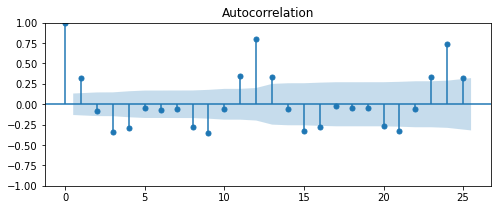

In [46]:
#ACF plot to get moving average variable
fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(train_diff, ax=ax, lags=25);

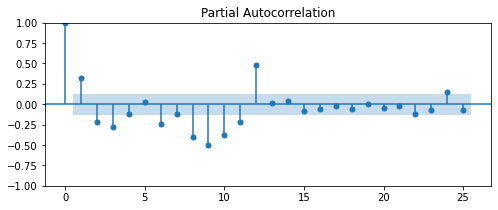

In [47]:
#plotting PACF to get autoregressive variable
fig, ax = plt.subplots(figsize=(8, 3))
plot_pacf(train_diff, ax=ax, lags=25, method="ywm");

In [48]:
#adding parameters from acf and pacf in to a second arma model to improve the first

arma_2 = ARIMA(train_diff, order=(13, 0, 9)).fit()


# Print out summary information on the fit
print(arma_2.summary())

                               SARIMAX Results                                
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                  221
Model:                ARIMA(13, 0, 9)   Log Likelihood               -2707.152
Date:                Mon, 01 Apr 2024   AIC                           5462.303
Time:                        16:33:41   BIC                           5543.859
Sample:                    02-01-2001   HQIC                          5495.234
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2966.9589   1656.227      1.791      0.073    -279.186    6213.103
ar.L1         -0.2792      0.894     -0.312      0.755      -2.032       1.474
ar.L2          0.0335      0.295      0.113      0.9

In [49]:
y_hat_arma2 = arma_2.predict(typ='levels')
rmse_arma2 = np.sqrt(mean_squared_error(train_diff, y_hat_arma2))
rmse_arma2

50986.88728731676

In [50]:
print('ar_1 AIC Score: ', ar_1.aic)
print('ar_2 AIC Score: ', ar_2.aic)
print('ma_1 AIC Score: ',  ma_1.aic)
print('ma_2 AIC Score: ', ma_2.aic)
print('arma_1 AIC Score: ', arma_1.aic)
print('arma_2 AIC Score: ', arma_2.aic)
print('=====================================')
print('ar_1 RMSE Score: ', rmse_ar1)
print('ar_2 RMSE Score: ', rmse_ar2)
print('ma_1 RMSE Score: ',  rmse_ma1)
print('ma_2 RMSE Score: ', rmse_ma2)
print('arma_1 RMSE Score: ', rmse_arma1)
print('arma_2 RMSE Score: ', rmse_arma2)

ar_1 AIC Score:  5786.857243413682
ar_2 AIC Score:  5783.544735234488
ma_1 AIC Score:  5741.158371072335
ma_2 AIC Score:  5715.560939174736
arma_1 AIC Score:  5675.532779493358
arma_2 AIC Score:  5462.303066304335
ar_1 RMSE Score:  123240.7663471049
ar_2 RMSE Score:  121758.42416977046
ma_1 RMSE Score:  109449.39895391688
ma_2 RMSE Score:  102586.24310891026
arma_1 RMSE Score:  87941.9756234161
arma_2 RMSE Score:  50986.88728731676


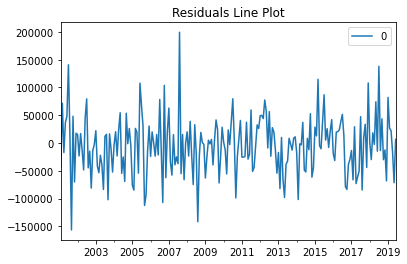

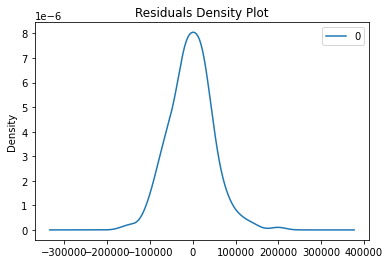

                   0
count     221.000000
mean    -4200.735509
std     50928.900784
min   -156233.488273
25%    -37038.741644
50%     -2747.698797
75%     25875.124698
max    199374.301678


In [51]:
# line plot of residuals
residuals = pd.DataFrame(arma_2.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Testing on Validation Data

In [52]:
valid_diff = valid.diff().dropna()

In [53]:
#using the same parameters as arma_2

arma_valid = ARIMA(valid_diff, order=(13, 0, 9)).fit()


# Print out summary information on the fit
print(arma_valid.summary())

                               SARIMAX Results                                
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                   54
Model:                ARIMA(13, 0, 9)   Log Likelihood                -675.047
Date:                Mon, 01 Apr 2024   AIC                           1398.094
Time:                        16:33:42   BIC                           1445.829
Sample:                    07-01-2019   HQIC                          1416.504
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        745.8149   2390.764      0.312      0.755   -3939.996    5431.626
ar.L1         -0.7727      1.957     -0.395      0.693      -4.608       3.063
ar.L2         -0.0229      3.329     -0.007      0.9

In [54]:
y_hat_valid = arma_valid.predict(typ='levels')
rmse_valid = np.sqrt(mean_squared_error(valid_diff, y_hat_valid))
rmse_valid

69057.11507076668

## Plotting ARMA 2 Model on Full Dataset

In [55]:
arma_full = ARIMA(natural_gas, order=(13, 0, 9)).fit()


# Print out summary information on the fit
print(arma_full.summary())

                               SARIMAX Results                                
Dep. Variable:      Natural Gas (Mcf)   No. Observations:                  276
Model:                ARIMA(13, 0, 9)   Log Likelihood               -3390.575
Date:                Mon, 01 Apr 2024   AIC                           6829.150
Time:                        16:33:44   BIC                           6916.039
Sample:                    01-01-2001   HQIC                          6864.017
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.082e+05    3.5e-07   2.31e+12      0.000    8.08e+05    8.08e+05
ar.L1          0.4041      0.932      0.434      0.665      -1.422       2.230
ar.L2         -0.1242      0.353     -0.351      0.7

In [56]:
y_hat_armafull = arma_full.predict(typ='levels')
rmse_valid = np.sqrt(mean_squared_error(natural_gas, y_hat_armafull))
rmse_valid

56295.0063895207

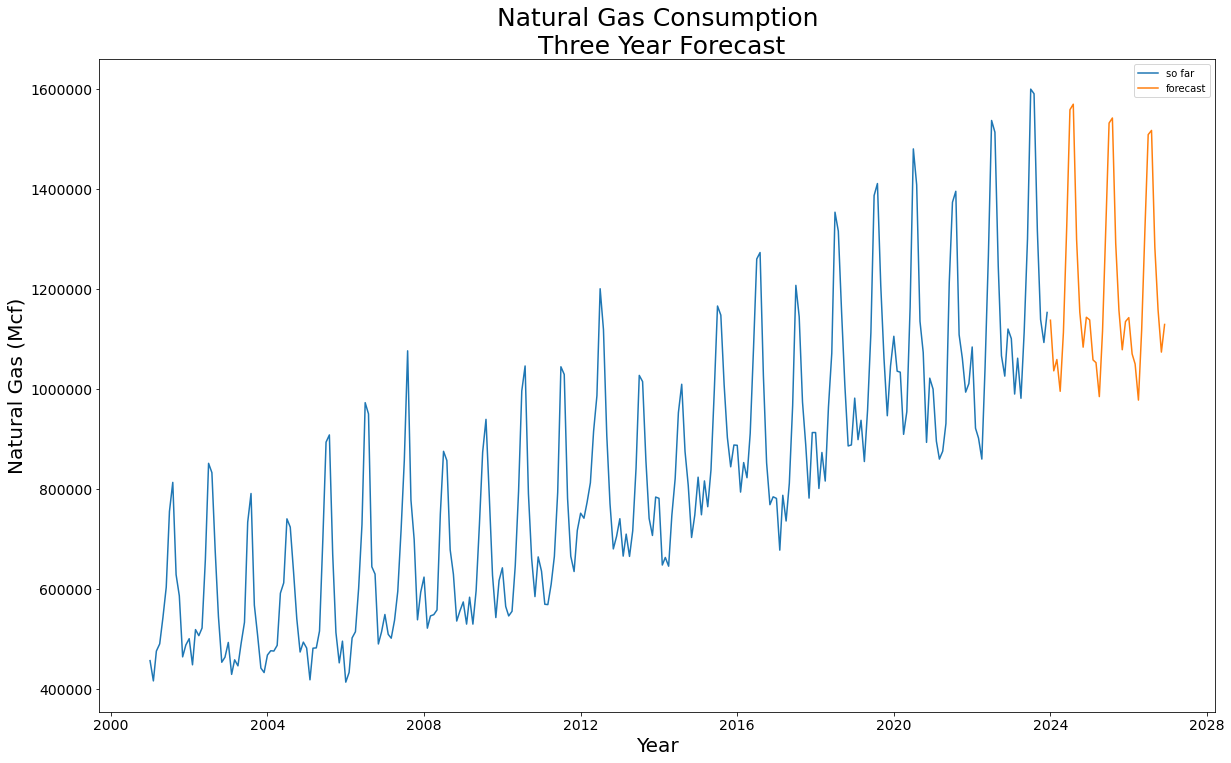

In [57]:
#plotting the three year forecast
forecast_arma_full = arma_full.forecast(steps=36)

fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(natural_gas, label='so far')
ax.plot(forecast_arma_full, label='forecast')
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Natural Gas Consumption\n Three Year Forecast', fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Natural Gas (Mcf)', fontsize=20)
plt.legend();

## SARIMAX Model

A SARIMAX model, which stands for Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors, is an extension of the ARIMA model. It is designed to handle time series data that not only have a trend and seasonality but are also influenced by external variables.


Seasonal (S): Captures the seasonality in the data, which are patterns that repeat over regular intervals, like daily, weekly, or yearly cycles.

Autoregressive (AR): Models the relationship between an observation and a specified number of lagged observations.
Integrated (I): Involves differencing the data to make it stationary, which means removing trends and seasonality from the data.

Moving Average (MA): Models the relationship between an observation and a residual error from a moving average model applied to lagged observations.

Exogenous Regressors (X): Allows the model to include external variables that could affect the time series but are not part of the series itself.


SARIMAX models are particularly useful for forecasting when data show patterns that repeat over time and when such patterns are influenced by external factors

In [58]:
#producing list of all possibilities for sarimax model parameters
p = q = range(0, 5)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (0, 1, 2, 52)
SARIMAX: (0, 1, 0) x (0, 1, 3, 52)
SARIMAX: (0, 1, 0) x (0, 1, 4, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 2, 52)
SARIMAX: (0, 1, 0) x (1, 1, 3, 52)
SARIMAX: (0, 1, 0) x (1, 1, 4, 52)
SARIMAX: (0, 1, 0) x (2, 1, 0, 52)
SARIMAX: (0, 1, 0) x (2, 1, 1, 52)
SARIMAX: (0, 1, 0) x (2, 1, 2, 52)
SARIMAX: (0, 1, 0) x (2, 1, 3, 52)
SARIMAX: (0, 1, 0) x (2, 1, 4, 52)
SARIMAX: (0, 1, 0) x (3, 1, 0, 52)
SARIMAX: (0, 1, 0) x (3, 1, 1, 52)
SARIMAX: (0, 1, 0) x (3, 1, 2, 52)
SARIMAX: (0, 1, 0) x (3, 1, 3, 52)
SARIMAX: (0, 1, 0) x (3, 1, 4, 52)
SARIMAX: (0, 1, 0) x (4, 1, 0, 52)
SARIMAX: (0, 1, 0) x (4, 1, 1, 52)
SARIMAX: (0, 1, 0) x (4, 1, 2, 52)
SARIMAX: (0, 1, 0) x (4, 1, 3, 52)
SARIMAX: (0, 1, 0) x (4, 1, 4, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) 

In [59]:
#this code block took over 12 hours to run. to cut down on processing time for the notebook I am commenting out the code. 
#the parameters with the best result were 'SARIMAX(0, 1, 0)x(0, 1, 4, 52) - AIC:10.0'

#for param in pdq:
   # for param_seasonal in seasonal_pdq:
       # try:
          #  mod=SARIMAX(train,
                        # order=param,
                       #  seasonal_order=param_seasonal,
                       #  enforce_stationarity=False,
                       #  enforce_invertibility=False)
          #  results = mod.fit()
          #  print('SARIMAX{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
     #   except: 
            # print('None')
          #  continue

In [60]:
#taking the parameteres that produced the best AIC score and putting them in to the model
sarimax =SARIMAX(train,
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 4, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                             Natural Gas (Mcf)   No. Observations:                  222
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2, 3, 4], 52)   Log Likelihood                   0.000
Date:                                       Mon, 01 Apr 2024   AIC                             10.000
Time:                                               16:33:52   BIC                                nan
Sample:                                           01-01-2001   HQIC                               nan
                                                - 06-01-2019                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52            0         -0        nan        nan           0           0
ma.S.L104           0         -0        nan        nan           0           0
ma.S.L156           0         -0        nan        nan           0           0
ma.S.L208           0         -0        nan        nan           0           0
sigma2      3.001e+10         -0       -inf      0.000       3e+10       3e+10
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [61]:
y_hat_sarimax = sarimax.predict(typ='levels')
rmse_sarimax = np.sqrt(mean_squared_error(train, y_hat_sarimax))
rmse_sarimax

162329.9094153656

In [62]:
print('ar_1 AIC Score:', ar_1.aic)
print('ar_2 AIC Score:', ar_2.aic)
print('ma_1 AIC Score:',  ma_1.aic)
print('ma_2 AIC Score:', ma_2.aic)
print('arma_1 AIC Score:', arma_1.aic)
print('arma_2 AIC Score:', arma_2.aic)
print('sarimax AIC Score:', sarimax.aic)
print('=====================================')
print('naive baseline:', rmse_baseline)
print('ar_1 RMSE Score:', rmse_ar1)
print('ar_2 RMSE Score:', rmse_ar2)
print('ma_1 RMSE Score:',  rmse_ma1)
print('ma_2 RMSE Score:', rmse_ma2)
print('arma_1 RMSE Score:', rmse_arma1)
print('arma_2 RMSE Score:', rmse_arma2)
print('sarimax RMSE Score:', rmse_sarimax)

ar_1 AIC Score: 5786.857243413682
ar_2 AIC Score: 5783.544735234488
ma_1 AIC Score: 5741.158371072335
ma_2 AIC Score: 5715.560939174736
arma_1 AIC Score: 5675.532779493358
arma_2 AIC Score: 5462.303066304335
sarimax AIC Score: 10.0
naive baseline: 108531.10297970324
ar_1 RMSE Score: 123240.7663471049
ar_2 RMSE Score: 121758.42416977046
ma_1 RMSE Score: 109449.39895391688
ma_2 RMSE Score: 102586.24310891026
arma_1 RMSE Score: 87941.9756234161
arma_2 RMSE Score: 50986.88728731676
sarimax RMSE Score: 162329.9094153656


In [63]:
sarimax_valid =SARIMAX(valid,
                   order=(0, 1, 0),
                  seasonal_order=(0, 1, 4, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

sarimax_valid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                             Natural Gas (Mcf)   No. Observations:                   55
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2, 3, 4], 52)   Log Likelihood                   0.000
Date:                                       Mon, 01 Apr 2024   AIC                             10.000
Time:                                               16:33:54   BIC                                nan
Sample:                                           06-01-2019   HQIC                               nan
                                                - 12-01-2023                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52            0         -0        nan        nan           0           0
ma.S.L104           0         -0        nan        nan           0           0
ma.S.L156           0         -0        nan        nan           0           0
ma.S.L208           0         -0        nan        nan           0           0
sigma2      1.058e+10         -0       -inf      0.000    1.06e+10    1.06e+10
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [64]:
y_hat_sarimax_valid = sarimax_valid.predict(typ='levels')
rmse_sarimax_valid = np.sqrt(mean_squared_error(valid, y_hat_sarimax_valid))
rmse_sarimax_valid

248972.62170892232

In [65]:
sarimax2 =SARIMAX(train,
                  order=(4, 1, 0),
                  seasonal_order=(0, 1, 0, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

sarimax2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  Natural Gas (Mcf)   No. Observations:                  222
Model:             SARIMAX(4, 1, 0)x(0, 1, 0, 52)   Log Likelihood               -2192.508
Date:                            Mon, 01 Apr 2024   AIC                           4395.017
Time:                                    16:33:55   BIC                           4410.547
Sample:                                01-01-2001   HQIC                          4401.321
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3246      0.085      3.804      0.000       0.157       0.492
ar.L2         -0.0096      0.076     -0.126      0.900      -0.159       0.140
ar.L3         -0.3052      0.080     -3.827      0.000      -0.462      -0.149
ar.L4         -0.1876      0.087     -2.147      0.032      -0.359      -0.016
sigma2      2.038e+10   4.61e-13   4.42e+22      0.000    2.04e+10    2.04e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 5.29
Prob(Q):                              0.58   Prob(JB):                         0.07
Heteroskedasticity (H):               1.16   Skew:                            -0.16
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+39. Standard errors may be unstable.
"""

In [66]:
y_hat_sarimax2 = sarimax2.predict(typ='levels')
rmse_sarimax2 = np.sqrt(mean_squared_error(train, y_hat_sarimax2))
rmse_sarimax2

137379.4903317759

## Plotting Sarimax Model

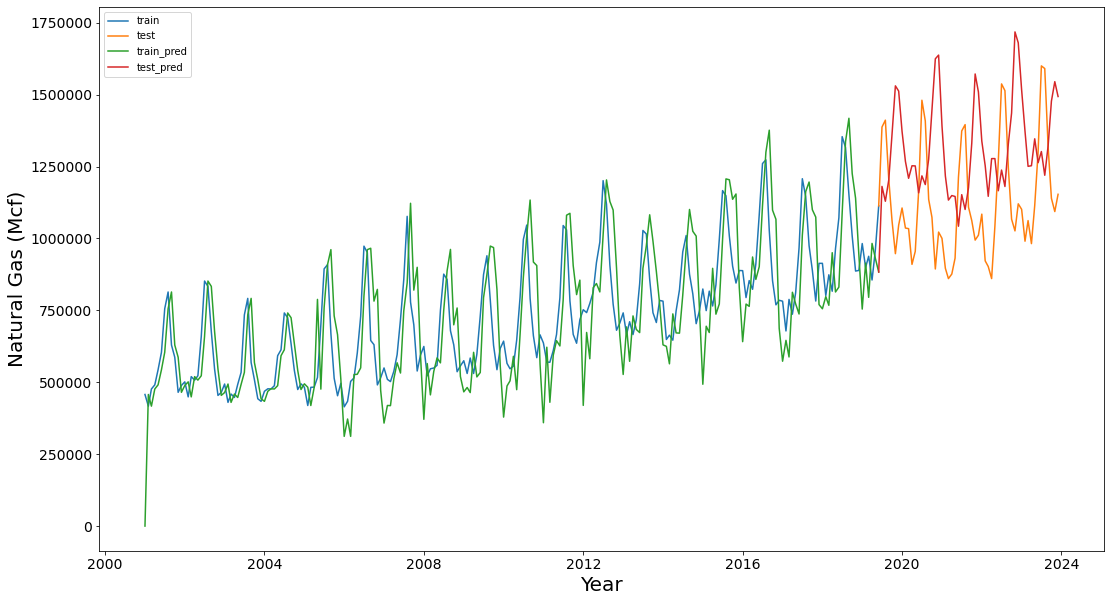

In [67]:
#plotting both the actual data and the predicted data
y_hat_train = sarimax.predict(typ='levels')
y_hat_test = sarimax.predict(start=valid.index[0], end=valid.index[-1],typ='levels')

fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(train, label='train')
ax.plot(valid, label='test')
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Natural Gas (Mcf)', fontsize=20)

plt.legend();

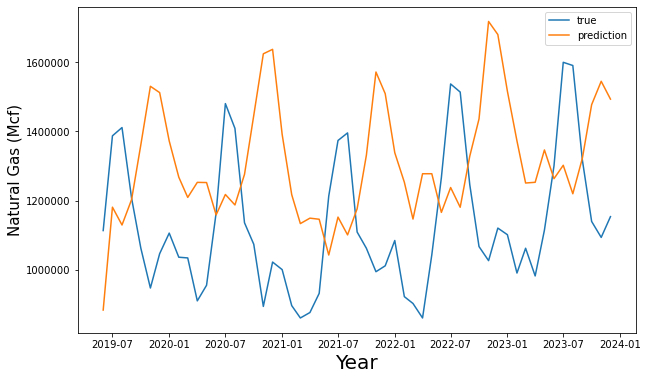

In [68]:
#zoomed in on the test set
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(valid, label='true')
ax.plot(y_hat_test, label='prediction')
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Natural Gas (Mcf)', fontsize=15)
plt.legend();

In [69]:
#running the model on the entire dataset together
sarimax_test = SARIMAX(natural_gas,
                 order=(0, 1, 0),
                  seasonal_order=(0, 1, 4, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [70]:
forecast = sarimax_test.forecast(steps=36)

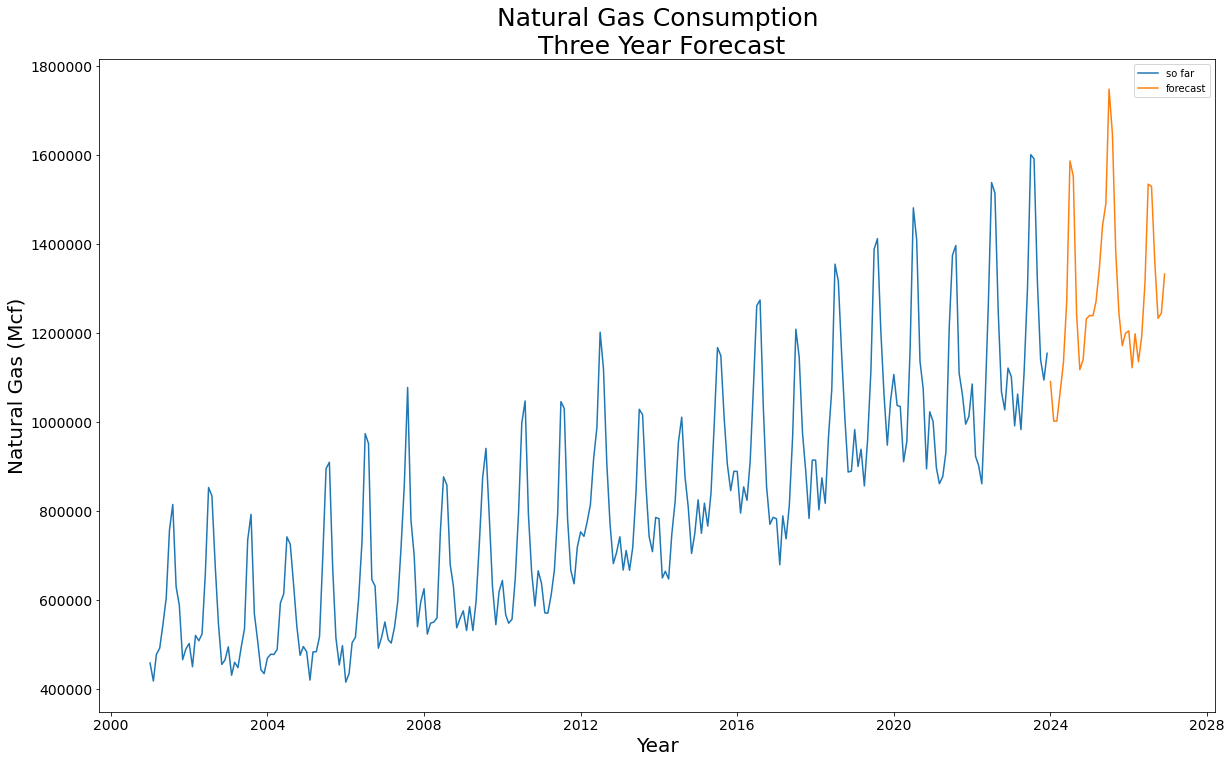

In [71]:
#plotting the three year forecast
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(natural_gas, label='so far')
ax.plot(forecast, label='forecast')
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Natural Gas Consumption\n Three Year Forecast', fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Natural Gas (Mcf)', fontsize=20)
plt.legend();

# Evaluation

The evaluation of predictive models for natural gas consumption indicates that the ARMA model outperforms the SARIMAX model. This conclusion is drawn from the comparison of the Akaike Information Criterion (AIC) and the Root Mean Square Error (RMSE) scores for both models. The ARMA model exhibits an AIC score of 5462.30, which, despite being higher than the SARIMAX’s AIC score of 10, suggests a better fit to the data when considering the context of the scores. Additionally, the ARMA model’s RMSE score of 50986.88 is significantly lower than the SARIMAX’s RMSE of 162329, indicating a more accurate prediction of natural gas consumption with less deviation from the observed values. These metrics collectively suggest that the ARMA model, with its lower complexity and better predictive accuracy, is more suitable for forecasting natural gas consumption in this scenario.

 The ARMA model’s better performance is also reflected in its ability to capture the dynamics of natural gas consumption without the need for the additional seasonal components that SARIMAX incorporates. While the SARIMAX model’s lower AIC score might suggest a better fit, the significantly higher RMSE points to less accurate predictions, which is critical for practical applications. In predictive modeling, especially for time series data, the goal is to achieve a balance between model complexity and predictive power. 

## Limitations

## Next Steps